# Dog Breed Identification: Machine Learning from Kaggle Competition

My name is André Fernandes and in this notebook is presented my solution proposal for the competition. Feel free to connect with me on LinkedIn and check out my other projects on GitHub:

[LinkedIn](https://www.linkedin.com)
[GitHub](https://www.linkedin.com/in/andr%C3%A9-fernandes-868006207/)

Below is the description of the competition and the link to the main page if you want to check it for yourself.

**Competition Description**

The Dog Breed Identification competition challenges participants to identify the breed of a dog in an image. This notebook will guide you through the process of building a predictive model that classifies dog breeds based on image data.

This competition is hosted on Kaggle: [Dog Breed Identification](https://www.kaggle.com/competitions/dog-breed-identification/overview)

## Table of Contents

1. Introduction
2. Data Description
3. Exploratory Data Analysis (EDA)
4. Data Preprocessing
5. Modeling
6. Model Evaluation
7. Conclusion
8. Usage
9. References

## Introduction

The Dog Breed Identification dataset is a collection of dog images categorized into various breeds. This notebook aims to develop a model that accurately classifies dog breeds based on image data.

## Data Description

The dataset consists of three main components:

- **train.zip**: The training dataset containing images of dogs and their corresponding breed labels.
- **test.zip**: The test dataset for which predictions need to be made.
- **labels.csv**: A CSV file containing the breed labels for the training dataset images.

## Exploratory Data Analysis (EDA)

...

## Data Preprocessing

...

## Modeling

...

## Model Evaluation

....

## Conclusion

...

## Usage

...

## References

- Kaggle Dog Breed Identification Competition: [Kaggle Dog Breed Identification](https://www.kaggle.com/competitions/dog-breed-identification/overview)
- ChatGPT

# Imports

In [3]:
# Manipulate data
import numpy as np
import pandas as pd
# Handleing files
import os
from PIL import Image
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Encode the labels
from sklearn.preprocessing import LabelEncoder
# Process data before modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
# For modeling
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# For model evaluation
from sklearn.metrics import classification_report

# Global constants/variables

In [5]:
# Constants
N_SAMPLES = 100 # For EDA (excluding IMG samples)
IMG_SIZE = 224 # This is popular size to performe image resizing
BATCH_SIZE = 32 # This is a usual batch size to use
N_CHANNELS = 3 # Number of channels of image, RGB
N_EPOCHES = 25 # Number of times the training process will run though the train data

# Working/Processing Labels

In [7]:
# Get the labels
labels = pd.read_csv('../data/labels.csv')

In [8]:
# Lets see labels info
labels.info()

# From here we can conclude that there are 10222 labels, that is, 10222 samples.
# Also, there are not Null values and that the labels are object type so they will need to be encoded.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [9]:
# Lets see the first five elements of the labels dataframe
labels.head()

# We can see that there are 2 collumns.
# The 'id' represents a unique representation of each image
# The 'breed' represents tha breed assign to each dog in the image

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# Now, lets add a new collumn to the labels, the image path
labels['img_path'] = labels['id'].apply(lambda x: os.path.join('../data/train', f'{x}.jpg'))
labels.info()

# We can confirm once again that there are no Nan values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10222 non-null  object
 1   breed     10222 non-null  object
 2   img_path  10222 non-null  object
dtypes: object(3)
memory usage: 239.7+ KB


In [11]:
# Lets see the first five elements of the new labels dataframe
labels.head()

,id,breed,img_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,../data/train\000bec180eb18c7604dcecc8fe0dba07...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,../data/train\001513dfcb2ffafc82cccf4d8bbaba97...
2,001cdf01b096e06d78e9e5112d419397,pekinese,../data/train\001cdf01b096e06d78e9e5112d419397...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,../data/train\00214f311d5d2247d5dfe4fe24b2303d...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,../data/train\0021f9ceb3235effd7fcde7f7538ed62...


There are 120 unique dog breeds.


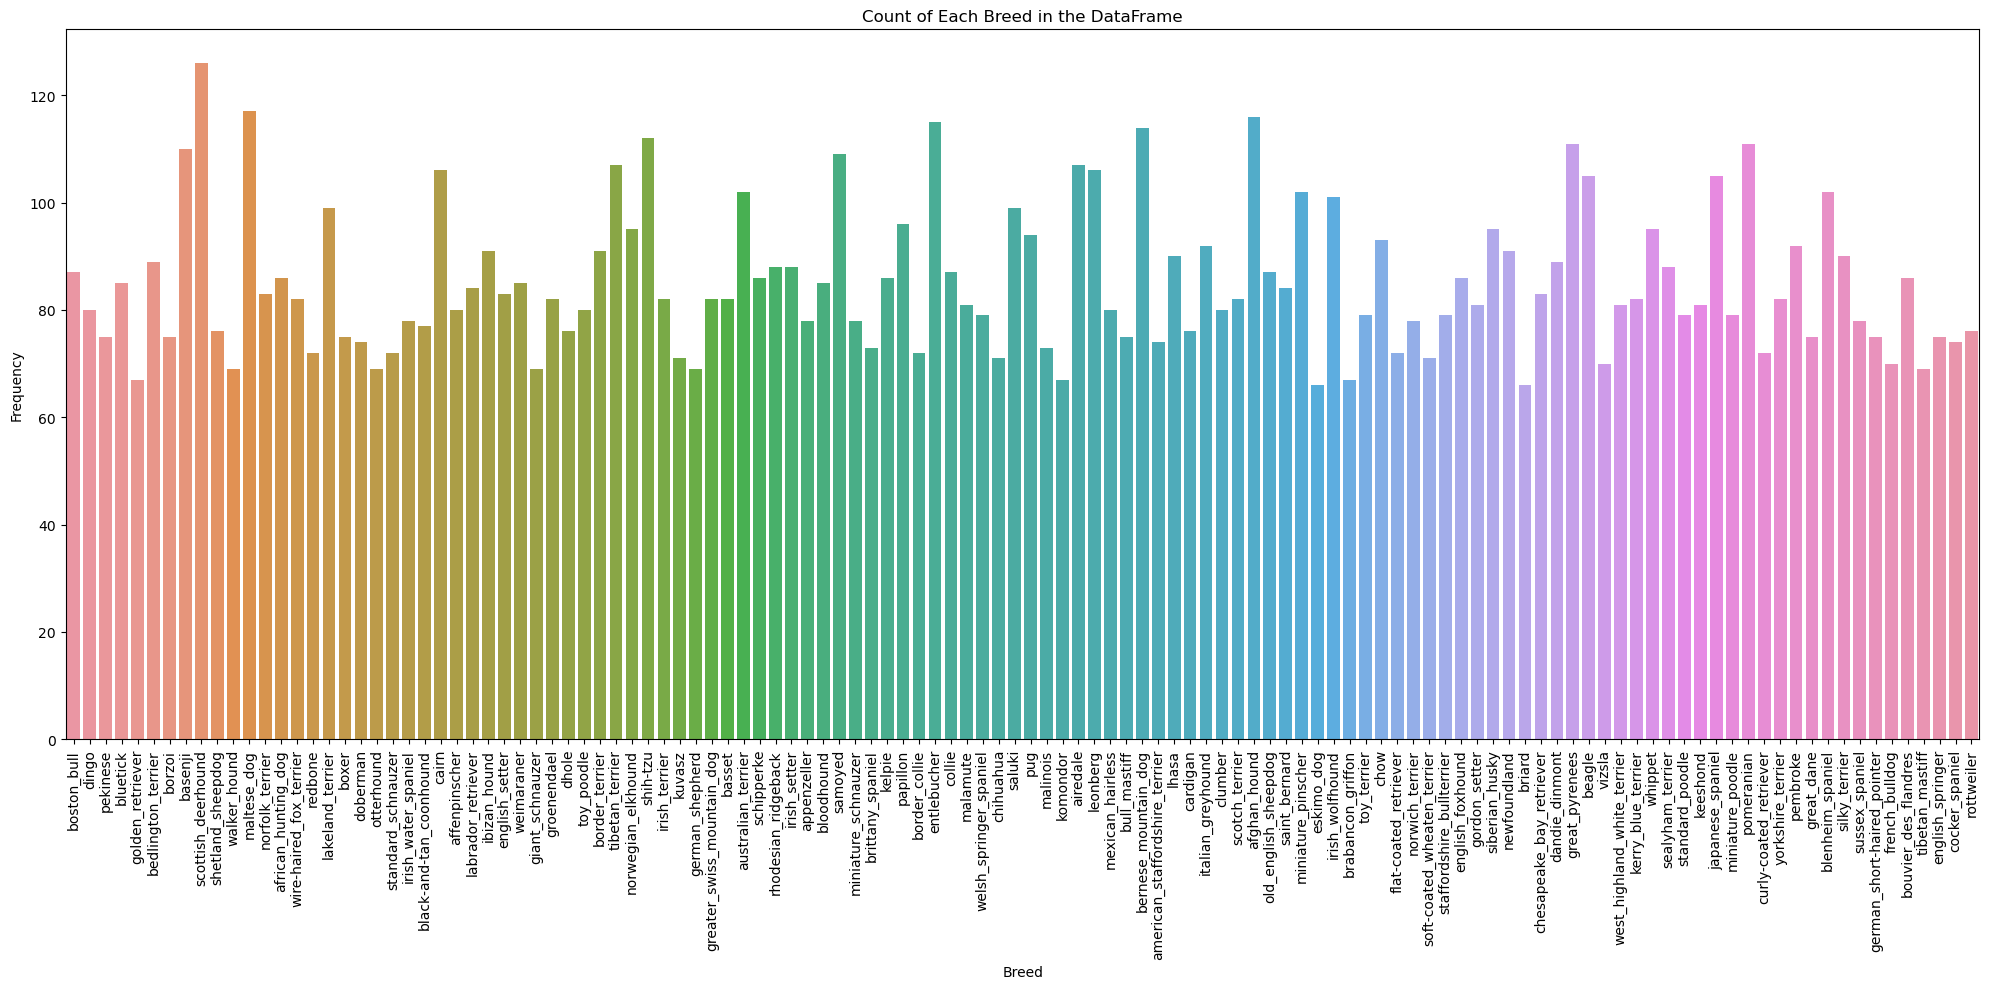

In [12]:
# Lets extract the number of breeds there are in the dataset
n_breeds = labels['breed'].nunique()
print(f"There are {n_breeds} unique dog breeds.")

# Create a seaboarn histogram to study the distribution of the breeds
plt.figure(figsize=(20, 10))
sns.countplot(data=labels, x='breed')
plt.xticks(rotation=90)
plt.xlabel('Breed')
plt.ylabel('Frequency')
plt.title('Count of Each Breed in the DataFrame')
plt.tight_layout()
plt.show()

# From this histogram we can conclude that there is no anomaly distribution in the number of each breed
# Beeing so, we can then encode the breed, the thing we are aiming to predict

In [13]:
# Lets define the LabelEncoder
label_encoder = LabelEncoder()
# Lets create a new collumn in the labels dataframe that representes the encoded breed
labels['breed_encoded'] = label_encoder.fit_transform(labels['breed'])

# Lets see the information
labels.info()

# So, for the first try we will be using the LabelEncoder()
# In the info, we can see that the type of the encodation is integers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             10222 non-null  object
 1   breed          10222 non-null  object
 2   img_path       10222 non-null  object
 3   breed_encoded  10222 non-null  int32 
dtypes: int32(1), object(3)
memory usage: 279.6+ KB


In [14]:
# Lets see the first five elements of the labels dataframe now, with the encoded breeds
labels.head()

# From here, we can conclude that each breed is now associeated with one number.
# This can possible lead our modle to give more importance to the breeds encoded with higher numbers so we have to have that in mind

,id,breed,img_path,breed_encoded
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,../data/train\000bec180eb18c7604dcecc8fe0dba07...,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,../data/train\001513dfcb2ffafc82cccf4d8bbaba97...,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,../data/train\001cdf01b096e06d78e9e5112d419397...,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,../data/train\00214f311d5d2247d5dfe4fe24b2303d...,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,../data/train\0021f9ceb3235effd7fcde7f7538ed62...,49


In [15]:
# Finally we can just confirm if there are no Null values
print("Number of Null values in each collumn of labels dataframe:\n")
print(labels.isnull().sum())

Number of Null values in each collumn of labels dataframe:

id               0
breed            0
img_path         0
breed_encoded    0
dtype: int64


# Perform some EDA on Images

In [17]:
def display_sample_images(labels_df, num_samples=5):
    '''
    Goal: display sample images from the dataframe

    Inputs: -> the dataframe
            -> the number of samples to display
    '''
    breeds = labels_df['breed'].unique()
    sample_images = []

    for breed in breeds[:num_samples]:
        # We filter the dataframe with only the breed 'breed' and then randomly sample 1 from it
        sample_image_path = labels_df[labels_df['breed'] == breed].sample(1)['img_path'].values[0]
        # Then we save the tuple in the array
        sample_images.append((breed, sample_image_path))

    plt.figure(figsize=(15, 10))
    for i, (breed, image_path) in enumerate(sample_images):
        image = Image.open(image_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(breed)
        plt.axis('off')
    plt.show()

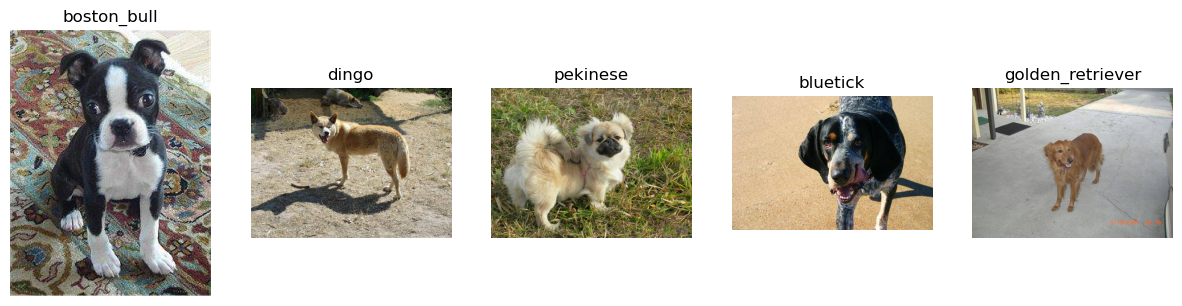

In [18]:
# Lets see some random images from the dataframe
display_sample_images(labels, num_samples=5)

Images Dimensions Imformation:

             Width       Height
count   100.000000   100.000000
mean    455.850000   390.390000
std     190.913613   140.668167
min     150.000000   190.000000
25%     375.000000   333.000000
50%     500.000000   375.000000
75%     500.000000   433.000000
max    2048.000000  1536.000000


C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


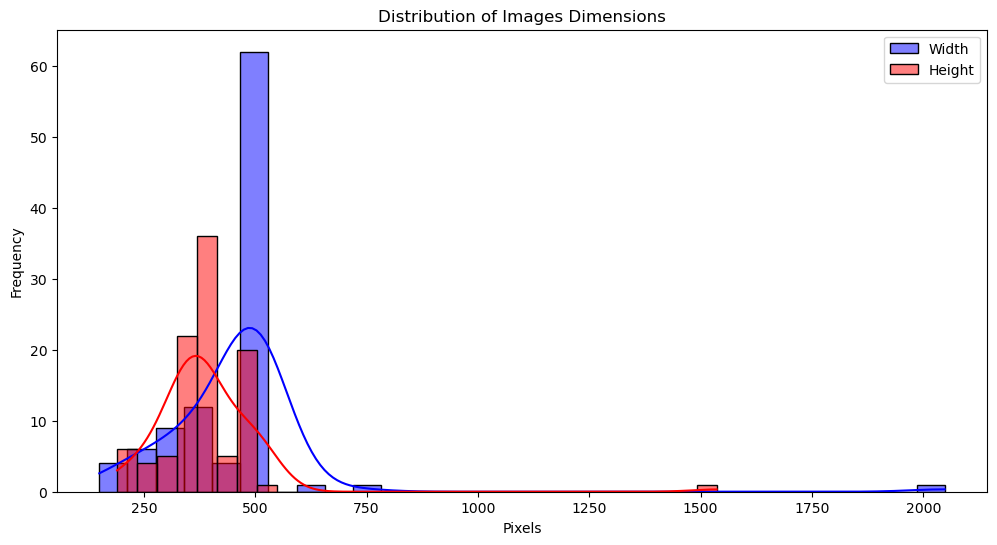

In [19]:
# Check image dimensions
image_shapes = []
for img_path in labels['img_path'].sample(N_SAMPLES):  # Sample for speed
    with Image.open(img_path) as img:
        image_shapes.append(img.size)

# Create a dataframe of the images shape
image_shapes_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
# Lets print it
print("Images Dimensions Imformation:\n")
print(image_shapes_df.describe()) # We can use the mean Width and mean Height to finetune IMG_SIZE to resize in the future

# Plot image dimensions
plt.figure(figsize=(12, 6))
sns.histplot(image_shapes_df['Width'], bins=30, color='blue', label='Width', kde=True)
sns.histplot(image_shapes_df['Height'], bins=30, color='red', label='Height', kde=True)
plt.title('Distribution of Images Dimensions')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [20]:
def analyze_pixel_intensity(image_path):
    '''
    Goal: analyze image pixel intensity distribution of one image

    Input: the path of an image

    Outputs: -> The mean intensity of pixels in the image
             -> The standard diviation of the pixels in the image
    '''
    image = Image.open(image_path)
    image_array = np.array(image)
    return image_array.mean(), image_array.std()

       Mean Intensity  Intensity Std
count      100.000000     100.000000
mean       118.268199      59.760790
std         29.903359      12.349489
min         61.505566      26.143177
25%         94.857316      51.729622
50%        116.543084      60.531050
75%        138.004122      68.783867
max        203.226836      85.602428


C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


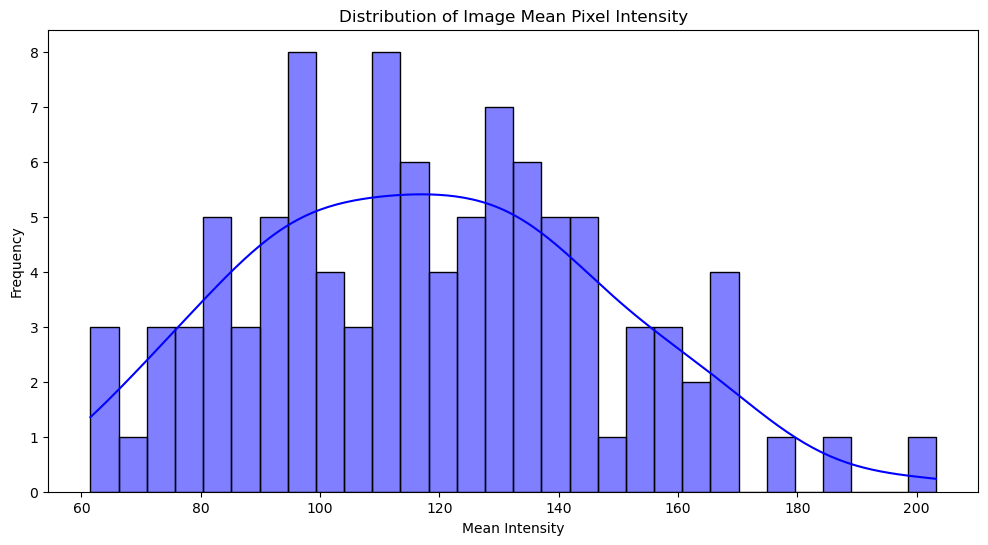

C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


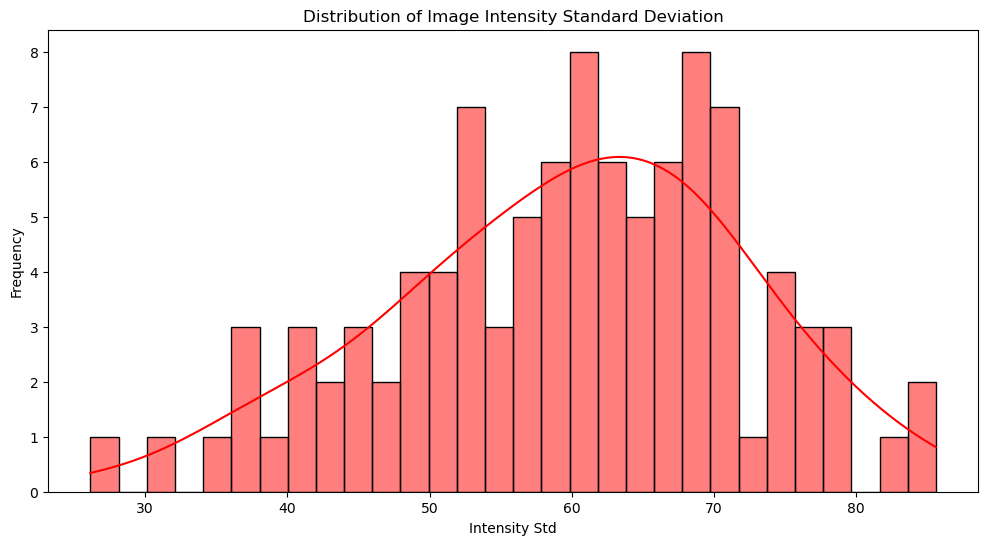

In [21]:
# Lets get analize the pixel_intensity of 100 random images
pixel_intensity_stats = [analyze_pixel_intensity(img_path) for img_path in labels['img_path'].sample(N_SAMPLES)]
# Lets create a dataframe for it
pixel_intensity_df = pd.DataFrame(pixel_intensity_stats, columns=['Mean Intensity', 'Intensity Std'])
# Lets print it
print(pixel_intensity_df.describe())

# Plot the distribution of image mean pixel intensity
plt.figure(figsize=(12, 6))
sns.histplot(pixel_intensity_df['Mean Intensity'], bins=30, color='blue', kde=True)
plt.title('Distribution of Image Mean Pixel Intensity')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of image pixel intensity standard deviation
plt.figure(figsize=(12, 6))
sns.histplot(pixel_intensity_df['Intensity Std'], bins=30, color='red', kde=True)
plt.title('Distribution of Image Intensity Standard Deviation')
plt.xlabel('Intensity Std')
plt.ylabel('Frequency')
plt.show()

# As we can see, both look like that their folling a normal distribuition which is postive.

# Working/Processing Train

In [23]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(labels, test_size=0.2, stratify=labels['breed_encoded'], random_state=42)

# First, we'll use the labels dataframe to split the dataset in training and validation.
# We can do this beacuse we have the images path in the labels dataframe.
# We will use a 20% split, that is, 80% of the data will be used to training and 20% for validation
# The random state allows us to test always in the same data split that is, all same images go to train and alll same images go to validation
#no matter the times we runn the code
# We use stratify in realtion to labels_df['breed_encoded'] to make a split so that the proportion of values in the sample produced will 
#be the same as the proportion of values. Ecample. If 25% of the data is 0's and 75% is 1's, each split will have 25% 0's and 75% 1's

In [24]:
def preprocess_image(image_path, label):
    '''
    Goal of function: pre-process images for training
    
    Inputs: -> image_path in the disk
            -> the label associated with the image
            
    Outputs: -> the image pre-processed
             -> the corresponding label of the pre-processed image
    '''
    
    # Read the image
    image = tf.io.read_file(image_path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=N_CHANNELS)
    # Resize the image
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Scale the image to [0, 1]
    image = image / 255.0
    return image, label

In [25]:
def augment_image(image, label):
    '''
    Goal of function: Apply data augmentation so our training set hcan help 
                     improve the robustness and generalization of your model by creating variations of the training data.

    Inputs: -> an image
            -> the image label

    Output: -> an image where all augmentation were appplyd
            -> the image label
    '''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    return image, label

# NOTE: The transformations (e.g., flips, brightness adjustments) are applied randomly each time an image is fetched from the dataset. 
#      Therefore, every epoch could potentially see a slightly different version of the same image.
# It is good because: -> there is no additional storage cost.
#                     ->  Each epoch, and even each batch, may see different augmentations, effectively increasing the diversity of the training data.
#                     -> Models trained with augmented data are generally more robust and better at generalizing to new, unseen data.

In [26]:
# Create TensorFlow datasets for the training dataframe; from_tensor_slices to convert from pandas dataframe to tf dataset.
train_ds = tf.data.Dataset.from_tensor_slices((train_df['img_path'], train_df['breed_encoded']))

# We are using TensorFlow datasets instead of Pandas dataframe beacause:
# Performance and Efficiency:
# -> Efficient Data Loading: TensorFlow Datasets can efficiently load, preprocess, and batch the data on the fly. 
#                            This reduces memory usage and leverages parallelism, ensuring that data is fed to the model quickly without 
#                            being bottlenecked by I/O operations.
# -> Prefetching: TensorFlow datasets support prefetching, which allows data to be prepared while the model is training. 
#                 This keeps the GPU/TPU utilized, minimizing idle times.

# Integration with TensorFlow/Keras:
# -> Seamless Integration: TensorFlow Datasets are designed to work seamlessly with TensorFlow and Keras. 
#                          They fit naturally into the model.fit method, supporting features like shuffling, batching, and preprocessing.

# Scalability:
# -> Handling Large Datasets: For large datasets that don’t fit into memory, TensorFlow Datasets can handle data 
#                            from multiple sources (e.g., files, databases) efficiently without loading everything into memory at once.
    
# Data Augmentation:
# -> On-the-fly Augmentation: TensorFlow datasets support on-the-fly data augmentation, which can be crucial for training 
#                            robust models without needing to store augmented data on disk.

# Lets see the first 5 lines
count = 0
for img, enc_label in train_ds:
    print(img, enc_label)
    count += 1
    if count == 5:
        break

tf.Tensor(b'../data/train\\2f812a0cb6977bbad1a167e1ef4ae2ac.jpg', shape=(), dtype=string) tf.Tensor(50, shape=(), dtype=int32)
tf.Tensor(b'../data/train\\123c19c8d168e7704273cb7174351821.jpg', shape=(), dtype=string) tf.Tensor(112, shape=(), dtype=int32)
tf.Tensor(b'../data/train\\3303feb629eef7ee44f6398c91745f73.jpg', shape=(), dtype=string) tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(b'../data/train\\5f14fac852ee51524997243f086e4ea2.jpg', shape=(), dtype=string) tf.Tensor(81, shape=(), dtype=int32)
tf.Tensor(b'../data/train\\8463aa43d88bee057082434ccc806bb0.jpg', shape=(), dtype=string) tf.Tensor(11, shape=(), dtype=int32)


In [27]:
# Now that we have the tf dataset we can pre-process
train_ds = train_ds.map(preprocess_image).map(augment_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Here, the .map applies a function to each element of the dataset. It appplies the preprocess_image fuction to every tuple
# After the image is pre-processed we create 
# The .batch groups consecutive elements of the dataset into batches of size BATCH_SIZE. Each batch will contain (img, label) * BATCH_SIZE pairs.
# Finaly, .prefetch ensures that while one batch of data is being processed by the model, the next batch is being prepared, reducing idle time.
# The AUTOTUNE option automatically tunes the prefetch buffer size for optimal performance.

# Lets see an example
print(next(iter(train_ds))) # The output is a batch, that is, there are 32 images

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.38870192, 0.49483386, 0.7001679 ],
         [0.38870192, 0.49483386, 0.7001679 ],
         [0.3913338 , 0.4974659 , 0.7027998 ],
         ...,
         [0.8464364 , 0.8883604 , 0.949221  ],
         [0.8545915 , 0.8907329 , 0.9544848 ],
         [0.8656674 , 0.90001196, 0.9685655 ]],

        [[0.39733723, 0.49884307, 0.7180555 ],
         [0.3993769 , 0.50088274, 0.7200952 ],
         [0.40055186, 0.50205773, 0.7212701 ],
         ...,
         [0.8615259 , 0.89864814, 0.9103253 ],
         [0.8669332 , 0.896982  , 0.9141322 ],
         [0.8760295 , 0.9042713 , 0.9313241 ]],

        [[0.3967153 , 0.50747347, 0.7220596 ],
         [0.39888662, 0.50964475, 0.724231  ],
         [0.39996758, 0.51072574, 0.725312  ],
         ...,
         [0.87847656, 0.90094596, 0.8658663 ],
         [0.8814142 , 0.900476  , 0.871179  ],
         [0.8928229 , 0.90855974, 0.88712096]],

        ...,

        [[0.36739635, 0.3902582 

In [28]:
# Now, we make the exact same thing but on the validation dataframe, that is, we convert it to ts Dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_df['img_path'], val_df['breed_encoded']))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Modeling - Using VGG16

In [30]:
# We will first be using the VGG16 by the Tranfer Learning mode
VGG16_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS), include_top=False, weights='imagenet')

# Here we import the VGG16 model. This is a CNN considered to be one of the best computer vision models to date.
#    - https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918

# When we use "include_top=False" we are excluding the fully connected layers and "weights='imagenet'" the model is pre-training on ImageNet.
# ImageNet is an image database - https://www.image-net.org/
# For more parameters: https://keras.io/api/applications/vgg/

In [31]:
# Lets say to the model that we dont want to train the layers of VGG16 because they are alredy pre-trained
for layer in VGG16_model.layers:
    layer.trainable = False

In [32]:
# Now, lets define the fully connected part of the model
first_model = Sequential([
    VGG16_model,
    Flatten(), # We flatten to prepare the output
    Dense(256, activation='relu'), # We define a fully connected layer with 256 nodes and 'relu' activation function
    Dropout(0.5), # We prevent overfitting by randomly define 50% of the input units will be randomly set to zero at each update during training time
    Dense(n_breeds, activation='softmax') # Then we define the output with 'softmax' because we want a probabiliti for each breed
])

In [33]:
# Now lets compile the model
first_model.compile(
    optimizer='adam', # Lets use 'adam' as the optimizer
    loss='sparse_categorical_crossentropy', # categorical_crossentropy is used when labels are encoded with ONE HOT ENCODE
    metrics=['accuracy']
)

In [34]:
# Finaly we train the model
history = first_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs= N_EPOCHES
)

Epoch 1/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 943s 4s/step - accuracy: 0.0101 - loss: 4.9924 - val_accuracy: 0.0122 - val_loss: 4.7848
Epoch 2/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 927s 4s/step - accuracy: 0.0108 - loss: 4.7849 - val_accuracy: 0.0122 - val_loss: 4.7826
Epoch 3/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 932s 4s/step - accuracy: 0.0113 - loss: 4.7814 - val_accuracy: 0.0122 - val_loss: 4.7810
Epoch 4/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 936s 4s/step - accuracy: 0.0107 - loss: 4.7893 - val_accuracy: 0.0122 - val_loss: 4.7797
Epoch 5/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 938s 4s/step - accuracy: 0.0107 - loss: 4.7821 - val_accuracy: 0.0122 - val_loss: 4.7787
Epoch 6/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 933s 4s/step - accuracy: 0.0122 - loss: 4.7880 - val_accuracy: 0.0122 - val_loss: 4.7779
Epoch 7/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 920s 4s/step - accuracy: 0.0120 - loss: 4.7873 - val_accuracy: 0.0122 - val_loss: 4.7773
Epoch 8/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 919s 4s/step - accuracy: 0.0108 - loss: 4.7776 - val_accu

# Evaluation - VGG16 MODEL

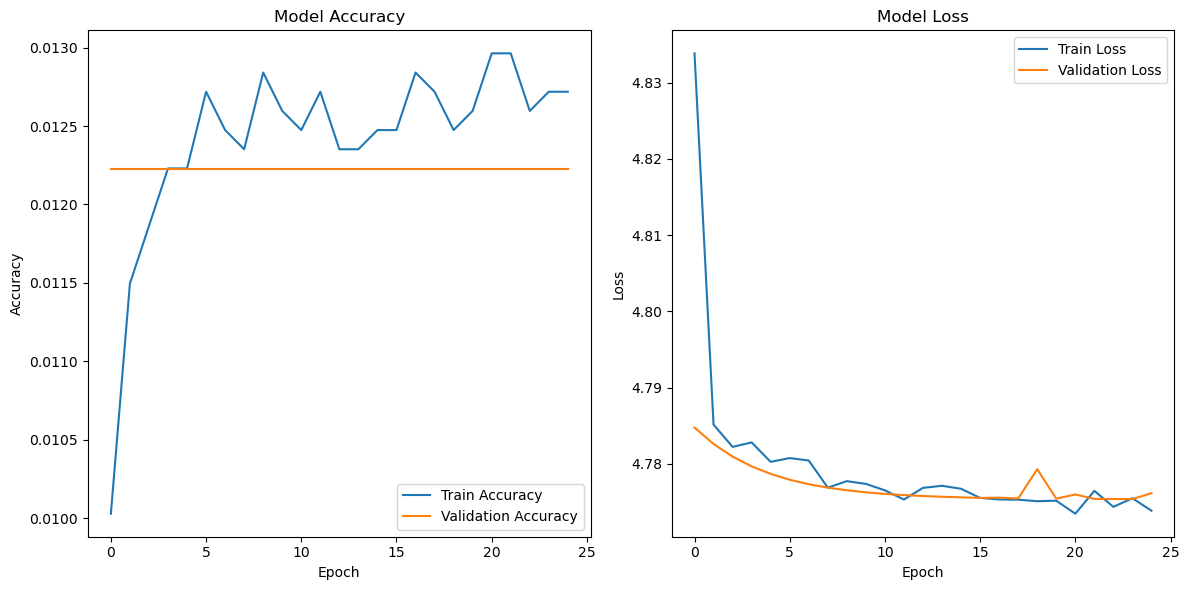

In [36]:
# Plotting Training and Validation Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plotting Training and Validation Loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

In [37]:
# Evaluation Metrics
val_ds = val_ds.unbatch()
y_true = np.concatenate([y for x, y in val_ds], axis=0)
val_ds = val_ds.batch(BATCH_SIZE)
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

ValueError: zero-dimensional arrays cannot be concatenated